# REFERENCES:
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://arxiv.org/pdf/1512.04150.pdf

https://pytorch.org/vision/stable/models.html

https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html

https://medium.com/the-dl/how-to-use-pytorch-hooks-5041d777f904

In [96]:
import io
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import json
from IPython import display 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import os

In [97]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        #Normalize
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

0.858 -> volcano
0.046 -> valley
0.024 -> alp
0.020 -> castle
0.007 -> barn
output CAM.jpg for the top1 prediction: valley


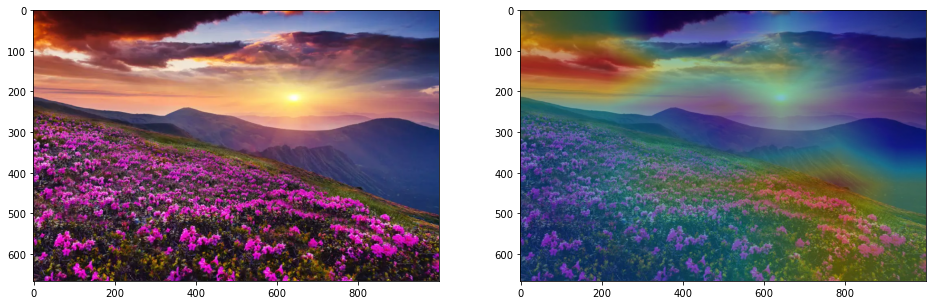

In [155]:
# input image
LABELS_file = 'imagenet-simple-labels.json'
image_file = 'img2.jpg'
net = models.resnet18(pretrained=True)
finalconv_name = 'layer4'

#set the network in evaluation mode
net.eval()

# hook the feature extractor to be executed at forward pass
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

# load test image
img_pil = Image.open(image_file).convert('RGB')
img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

# load the imagenet category list
with open(LABELS_file) as f:
    classes = json.load(f)

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [1])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[1]])
img = cv2.imread(image_file)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result);
# figure size in inches optional
rcParams['figure.figsize'] = 16 ,9

# read images
img_A = mpimg.imread(image_file)
img_B = mpimg.imread("CAM.jpg")

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);

In [151]:

for i in range(1000):
    print(classes[idx[i]],idx[i])

volcano 980
valley 979
alp 970
castle 483
barn 425
promontory 976
tent 672
church 497
lighthouse 437
stone wall 825
lakeshore 975
poncho 735
balloon 417
scarf 824
viaduct 888
greenhouse 580
picket fence 716
cliff 972
seashore 978
split-rail fence 912
dam 525
thatched roof 853
maze 646
front curtain 854
radio telescope 755
coral reef 973
sarong 775
hay 958
patio 706
stupa 832
monastery 663
yurt 915
binoculars 447
mountain bike 671
stage 819
rapeseed 984
megalith 649
tile roof 858
breakwater 460
boathouse 449
semi-trailer truck 867
suspension bridge 839
flagpole 557
palace 698
chain-link fence 489
planetarium 727
spotlight 818
shoal 977
geyser 974
pinwheel 723
conch 112
goldfish 1
cloak 501
feather boa 552
recreational vehicle 757
marmot 336
wool 911
wing 908
coil 506
fountain 562
tub 876
sunglasses 837
bubble 971
torch 862
parachute 701
bathtub 435
maypole 645
mask 643
eel 390
unicycle 880
mobile home 660
grand piano 579
tripod 872
canoe 472
Entlebucher Sennenhund 241
velvet 885
starfis

parallel bars 702
sewing machine 786
bustard 138
wallet 893
Dandie Dinmont Terrier 194
American dipper 20
slot machine 800
mop 840
garter snake 57
whiskey jug 901
eggnog 969
radio 754
tiger cat 282
bow 456
black-footed ferret 359
Petri dish 712
duck 97
African bush elephant 386
consomme 925
lynx 287
gossamer-winged butterfly 326
cheeseburger 933
beaver 337
electric fan 545
pulled rickshaw 612
stick insect 313
packet 692
stretcher 830
hippopotamus 344
chameleon 47
common gallinule 136
window shade 905
carbonara 959
threshing machine 856
rugby ball 768
joystick 613
grey parrot 87
computer mouse 673
military cap 439
Sealyham Terrier 190
hot pot 926
eraser 767
scorpion 71
weighing scale 778
holster 597
ring binder 446
strainer 828
dugong 149
hand-held computer 590
bee eater 92
black stork 128
titi 380
Mexican hairless dog 268
leopard 288
black swan 100
spoonbill 129
cocktail shaker 503
power drill 740
gorilla 366
mousetrap 674
nipple 680
bassinet 431
Egyptian Mau 285
flamingo 130
echidna 1